In [2]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [24]:
!pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/1c/07/512f6a780239ad6ce06ce2aa7b4067583f5ddcfc7703a964a082c706a070/mlxtend-0.23.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.4 MB 438.1 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.4 MB 481.4 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 481.4 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 481.4 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.4 MB 420.1 kB/s eta 0:00:04
   ------ --------------------------------- 0.2/1.4 MB 474.7 kB/s

In [4]:
#Reading data
myretaildata = pd.read_excel('Sales12m.xlsx')

# Display the first 15 rows of the DataFrame
myretaildata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82340 entries, 0 to 82339
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Transacti                 82340 non-null  datetime64[ns]
 1   Product                   82340 non-null  object        
 2   Detail R                  82340 non-null  int64         
 3   Product Base Description  82340 non-null  object        
 4   Line Ext                  82340 non-null  object        
 5   Line GST $                82340 non-null  float64       
 6   Trading Name              61144 non-null  object        
 7   Contact Given Names       25003 non-null  object        
 8   Contact Surname           22127 non-null  object        
 9   Contact Email Address     21938 non-null  object        
 10  Delive                    21819 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 6.9+ MB


## **Data Preparation**

In [5]:
myretaildata['Product Base Description'] = myretaildata['Product Base Description'].str.strip() #remove space from begining
myretaildata.dropna(axis=0, subset=['Detail R'], inplace=True)#remove nan invoice
myretaildata = myretaildata[~myretaildata['Product Base Description'].isin(['SETUP CHARGE REBATE SINGLE', 'MACHINE FEED/RUN CHARGE P/M', 'RUN CHARGE STANDARD PER M', 'SETUP CHARGE RIPPING'])]
#myretaildata['InvoiceNo'] = myretaildata['InvoiceNo'].astype('str') #converting invoice number to be string
#remove mistake transactions
myretaildata['Quantity'] = 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Index: 532603 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532603 non-null  object        
 1   StockCode    532603 non-null  object        
 2   Description  531148 non-null  object        
 3   Quantity     532603 non-null  int64         
 4   InvoiceDate  532603 non-null  datetime64[ns]
 5   UnitPrice    532603 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      532603 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.6+ MB


In [6]:
df_top_product_sold=myretaildata['Product Base Description'].value_counts()


In [13]:

df_top_post=myretaildata['Delive'].value_counts()

In [12]:
#Separating transactions for creating a basket
mybasket = (myretaildata
            .groupby(['Detail R', 'Product Base Description'])['Quantity']
            .sum().unstack().reset_index().fillna(0)
            .set_index('Detail R'))
mybasket.shape


(36249, 6468)

In [9]:
#Converting all positive values to 1 and everything else to 0
def my_encode_units(x):
  if x <= 0:
    return 0
  if x >= 1:
    return 1
my_basket_sets = mybasket.applymap(my_encode_units)


## training a model

In [14]:
#Generating Frequent itemsets
# Adjust the support threshold to a lower value
min_support = 0.002  # You can adjust this value as needed
# Adjust the lift threshold to a lower value
min_lift = 0.01  # You can adjust this value as needed
# Generating frequent itemsets
my_frequent_itemsets = apriori(my_basket_sets, min_support=min_support, use_colnames=True)
# Generating rules with lower support and lift thresholds
my_rules = association_rules(my_frequent_itemsets, metric="lift", min_threshold=min_lift)

# Sort the association rules by support in descending order
my_rules_sorted = my_rules.sort_values(by='support', ascending=False)


C:\Users\sum77\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


#### If we print myrules we can see all the possible sets which had high frequency of buying together. 

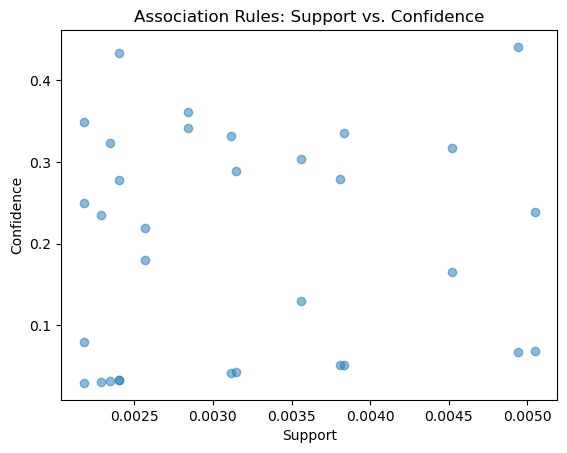

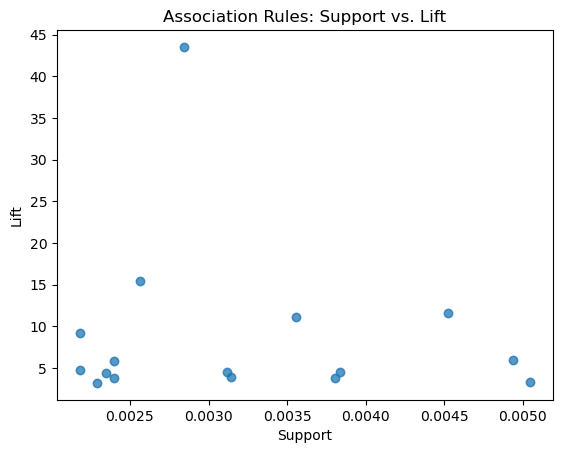

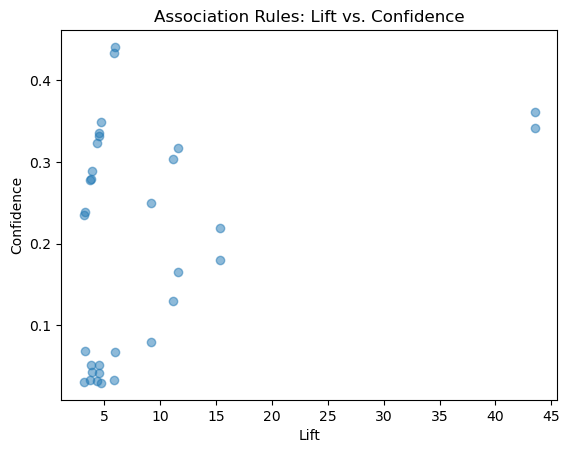

In [102]:
import matplotlib.pyplot as plt

# Plotting support vs. confidence
plt.scatter(my_rules['support'], my_rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs. Confidence')
plt.show()

# Plotting support vs. lift
plt.scatter(my_rules['support'], my_rules['lift'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Association Rules: Support vs. Lift')
plt.show()

# Plotting lift vs. confidence
plt.scatter(my_rules['lift'], my_rules['confidence'], alpha=0.5)
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Association Rules: Lift vs. Confidence')
plt.show()


# Product set having higher lift and higher confidence are among the best performers for market basket analysis.In this way, i have used Market Basket analysis. There are still more things we have done to improve the results.